**Closed Loop Errors Demo**

Make sure the ERA5 Wind Data is downloaded from the following link:
https://drive.google.com/file/d/1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf/view?usp=sharing

Make sure it's saved into your Google Drive (in the main drive, not within a subfolder).

# **Installations**

In [ ]:
# Clone the repository
import os
import sys

git_path = '/content/balloon-outreach'
if os.path.exists(git_path):
    print("✅ Found:", git_path)
    sys.path.append('/content/balloon-outreach/')
    %cd balloon-outreach/
else:
    print("❌ Not found:", git_path)
    !git clone https://github.com/sdean-group/balloon-outreach.git
    %cd balloon-outreach
    !git checkout main

In [ ]:
# Install required packages
!pip install -r requirements.txt

In [ ]:
from google.colab import drive
import gdown
import os

# 1. Mount your Drive
drive.mount('/content/drive')

# 2. Check existence
if os.path.exists('/content/drive/My Drive/era5_data.nc'):
    print("✅ Found:", '/content/drive/My Drive/era5_data.nc')
    datapath = '/content/drive/My Drive/era5_data.nc'
    
elif os.path.exists("/content/balloon-outreach/era5_data.nc"):
    print("✅ Found:", "/content/balloon-outreach/era5_data.nc")
    datapath = "/content/balloon-outreach/era5_data.nc"

else:
    print("❌ Not found")
    # Download ERA5 data
    file_id = "1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf"
    url = f"https://drive.google.com/uc?id={file_id}"
    output = "era5_data.nc"
    gdown.download(url, output, quiet=False)
    datapath = "/content/balloon-outreach/era5_data.nc"


In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from math import cos, radians
from datetime import datetime
from env.ERA_wind_field import WindField

import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [3]:
# Ensure download worked
ds = xr.open_dataset(datapath, engine='netcdf4')
print(ds)

<xarray.Dataset> Size: 3GB
Dimensions:         (valid_time: 120, pressure_level: 7, latitude: 361,
                     longitude: 1440)
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 960B 2024-07-01 ... 2024-07-0...
  * pressure_level  (pressure_level) float64 56B 1e+03 850.0 ... 200.0 100.0
  * latitude        (latitude) float64 3kB 90.0 89.75 89.5 ... 0.5 0.25 0.0
  * longitude       (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    expver          (valid_time) <U4 2kB ...
Data variables:
    u               (valid_time, pressure_level, latitude, longitude) float32 2GB ...
    v               (valid_time, pressure_level, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
  

# **Sampling noisy wind vectors**

The code below demonstrates how getting the wind at the same longitude and latitude is different for noiseless and noisy wind.

In [4]:
# 1. pick a reference start_time (should match your dataset’s first valid_time)
start_time = datetime(2024, 7, 1, 0, 0)

# 2. wrap it, giving an explicit seed for reproducibility
start = time.time()
wf = WindField(ds, start_time, add_noise=False)
end = time.time()
print(f"WindField initialized for {end - start:.4f} seconds. \n")

# 3. query at (lon, lat, pressure, elapsed_time)
start = time.time()
wf.disable_noise()
pt = wf.get_wind(
    lon          = -75.04,
    lat          =  40.33,
    pressure     =  400.0,
    elapsed_time =  1.3  # in hours
)
end=time.time()
print(f"Noiseless: u={pt.u:.2f}, v={pt.v:.2f}")
print(f"Elapsed: {end - start:.4f} seconds")
print('\n')

# Slightly different wind vector for each iteration, which reflects reality more accurately
wf.enable_noise(noise_seed=None)
print("Noisy Samples")
for i in range(5):
    start = time.time()
    wf.reset_noise(noise_seed=i)   # picks a fresh random seed internally
    pt = wf.get_wind(
        lon          = -75.04,
        lat          =  40.33,
        pressure     =  400.0,
        elapsed_time =  1.3  # in hours
    )
    end=time.time()
    print(f"draw {i+1}: u={pt.u:.2f}, v={pt.v:.2f}")
    print(f"Elapsed: {end - start:.4f} seconds\n")

WindField initialized with noise enabled: False, scale: 1.0
WindField initialized for 19.1440 seconds. 

Noiseless: u=28.24, v=7.70
Elapsed: 0.0013 seconds


Noisy Samples
draw 1: u=29.53, v=6.61
Elapsed: 0.0196 seconds

draw 2: u=28.32, v=5.97
Elapsed: 0.0182 seconds

draw 3: u=25.50, v=7.13
Elapsed: 0.0189 seconds

draw 4: u=28.34, v=8.25
Elapsed: 0.0151 seconds

draw 5: u=27.92, v=7.71
Elapsed: 0.0154 seconds



# **Generating Tree Search Actions**

This section demonstrates planning actions in a noiseless environment can be different in noisy environment.

*WindField with no noise*

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from env.balloon_env import BalloonERAEnvironment
from agent.tree_search_agent import run_astar_fly_as_far_as_possible, DiscretizeConfig

# ------PARAMETERS---------
initial_lat, initial_lon = 42.6, -76.5 #deg
initial_alt = 10.0 #km
initial_volume = 1000.0  # Initial volume (m³)
initial_sand = 100  # Initial sand mass (kg)
start_time_np = ds.valid_time.values[0]
start_time = pd.to_datetime(start_time_np).to_pydatetime()
duration_seconds = 24*3600
dt_seconds = 60
n_steps = int(duration_seconds / dt_seconds)

# For visualization
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

# Configuration parameters
use_simplified_step = True  # Use simplified step for A* search
lat_long_atol = 1e-1        # Tolerance for latitude and longitude (degrees)
alt_atol = 1                # Tolerance for altitude (km)
environment_step = 1200     # Environment step (s)
max_iter = 2000           # Maximum iterations for A* search
max_depth = 10            # Maximum depth for A* search (in discrete timesteps) - None means no limit.
discretization_config = DiscretizeConfig(use_discretization=True, decimals=1)

np.random.seed(0)  # For reproducible results
#-----------------------------

WindField initialized with noise enabled: False, scale: 1.0
Discretized initial state: [ 42.6 -76.5  10.    0. ]


A* Search Progress: 100%|██████████| 2000/2000 [00:26<00:00, 75.33iteration/s]


Max iterations reached. Stopping search.
A* completed. Returning best action sequence found.


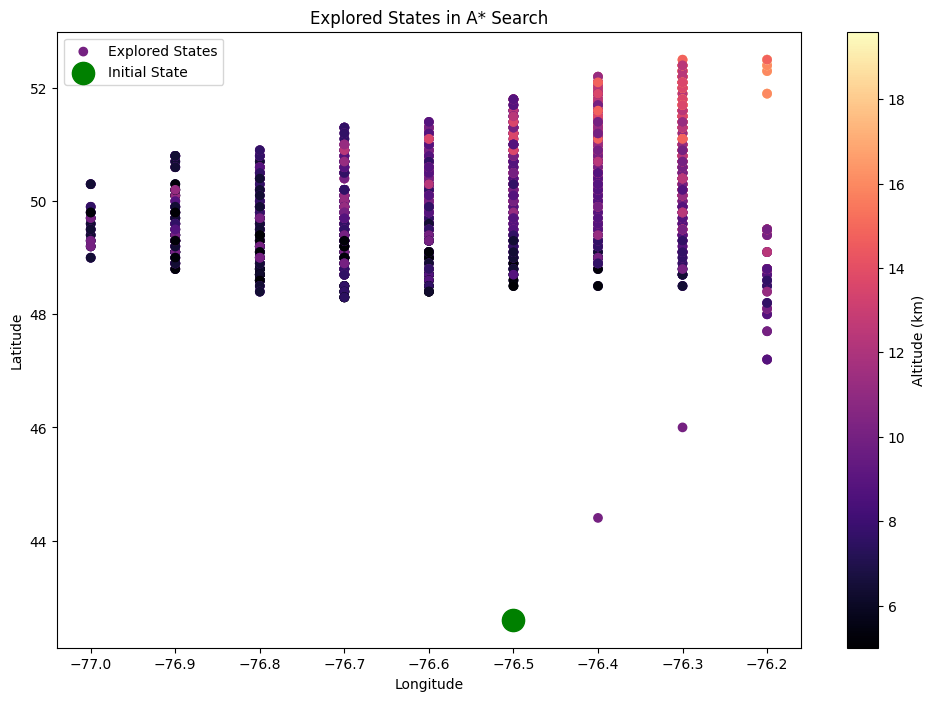

Action sequence (flying as far as possible): [((42.6, -76.5, 10.0, 0.0), 'stay'), ((44.4, -76.4, 10.0, 0.3), 'stay'), ((46.0, -76.3, 10.0, 0.7), 'ascend'), ((47.2, -76.2, 11.2, 1.0), 'ascend'), ((48.1, -76.2, 12.4, 1.3), 'ascend'), ((48.8, -76.2, 13.6, 1.7), 'ascend'), ((49.5, -76.3, 14.8, 2.0), 'ascend'), ((50.3, -76.3, 16.0, 2.3), 'stay'), ((51.1, -76.3, 16.0, 2.7), 'ascend'), ((51.8, -76.3, 17.2, 3.0), 'stay'), ((52.5, -76.2, 17.2, 3.3), None)]
Found path with 11 steps


<Figure size 1200x800 with 0 Axes>

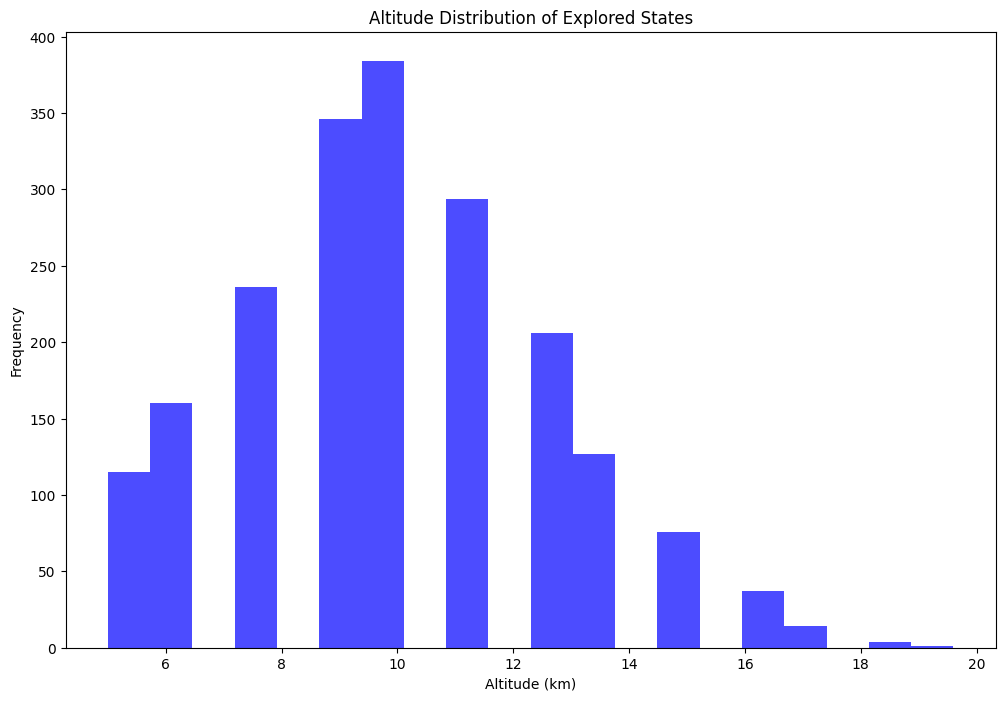

In [6]:
# BalloonERAEnvironment initialization
start_time = dt.datetime(2024, 7, 1, 0, 0)
env = BalloonERAEnvironment(initial_lat=42.6, initial_lon=-76.5, initial_alt=10.0,
                            target_lat= None, target_lon=None, target_alt=None, 
                            ds=ds, start_time=start_time, viz=False, add_noise=False, objective='fly', dt=environment_step)
initial_state = env.get_balloon_state()  # Get the initial state of the balloon
start_state = np.array([42.6, -76.5, 10.0])

env.set_balloon_state(initial_state)
optimal_path = run_astar_fly_as_far_as_possible(env, initial_lat=start_state[0], initial_long=start_state[1], initial_alt=start_state[2],
            plot_suffix="test_era_notebook", simplified_step=True,
            max_iter=max_iter, max_depth=max_depth, discretize_config=discretization_config)

if optimal_path:
    print(f"Found path with {len(optimal_path)} steps")
else:
    print("No path found within iteration limit")


tree_actions = []
for info, action in optimal_path:
  if action == 'stay':
    tree_actions.append(0.0)
  elif action == 'descend':
    tree_actions.append(-1.0)
  else:
    tree_actions.append(1.0)

tree_trajectory = []
for state in (optimal_path):
  tree_trajectory.append(state[0][:3])

# **Plot Balloon Trajectory with Tree Search Actions**

We can now plot the balloon's path with these actions in the noiseless and noisy environment to see the difference in their trajectories.

In [ ]:
def get_trajectory_info(env, n_steps, action_list):
    env.balloon.vertical_velocity = 0.0
    altitudes = []
    latitudes = []
    longitudes = []
    
    latitudes.append(env.balloon.lat)
    longitudes.append(env.balloon.lon)
    altitudes.append(env.balloon.alt)
    
    # Run simulation
    for i in range(n_steps):
        state, _, _, _ = env.step(action_list[i])
        latitudes.append(env.balloon.lat)
        longitudes.append(env.balloon.lon)
        altitudes.append(env.balloon.alt)

    return longitudes, latitudes, altitudes

# Plots the trajectory on a map
def plot_trajectory_map(lons, lats, lons2=None, lats2=None):
    fig, ax = plt.subplots(
        figsize=(12,6),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    ax = plt.axes(projection=ccrs.PlateCarree())

    # around the North America
    lon_min, lon_max = min(lons)-10, max(lons)+10
    lat_min, lat_max = min(lats)-10, max(lats)+10
    
    if lons2 is not None and lats2 is not None:
        lon_min, lon_max = min(min(lons2)-10, lon_min), max(max(lons2)+10, lon_max)
        lat_min, lat_max = min(min(lats2)-10, lat_min), max(max(lats2)+10, lat_max)

    ax.set_extent([lon_min, lon_max, lat_min, lat_max],
                crs=ccrs.PlateCarree())

    # add background
    ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='lightblue')
    ax.coastlines('50m', linewidth=0.5)

    # gridlines with labels
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False

    # plot trajectory
    ax.plot(lons, lats,
            transform=ccrs.PlateCarree(),
            color='blue', linewidth=2,
            label='Trajectory')

    # start and end markers
    ax.scatter(lons[0], lats[0],
            transform=ccrs.PlateCarree(),
            color='green', marker='o', s=60,
            label='Start')
    ax.scatter(lons[-1], lats[-1],
            transform=ccrs.PlateCarree(),
            color='red', marker='X', s=60,
            label='End')

    if lons2 is not None and lats is not None:
        ax.plot(lons2, lats2,
                transform=ccrs.PlateCarree(),
                color='purple', linewidth=2,
                label='Noisy Trajectory')
        
        ax.scatter(lons2[-1], lats2[-1],
                transform=ccrs.PlateCarree(),
                color='orange', marker='X', s=60,
                label='End')

    ax.set_title(f"Balloon Trajectory with Wind Field")
    ax.set_xlabel("Longitude (°E)")
    ax.set_ylabel("Latitude (°N)")
    ax.legend(loc='lower left')

    plt.show()

Compare the differences between the two trajectories below:

Without Noisy WindField:

In [ ]:
env = BalloonERAEnvironment(initial_lat=42.6, initial_lon=-76.5, initial_alt=10.0,
                            target_lat= None, target_lon=None, target_alt=None, 
                            ds=ds, start_time=start_time, viz=False, add_noise=False, objective='fly', dt=environment_step)

longitudes, latitudes, altitudes = get_trajectory_info(env, len(tree_actions), tree_actions)

noisy_env = BalloonERAEnvironment(initial_lat=42.6, initial_lon=-76.5, initial_alt=10.0,
                            target_lat= None, target_lon=None, target_alt=None, 
                            ds=ds, start_time=start_time, viz=False, add_noise=True, noise_scale=20.0, noise_seed=100, objective='fly', dt=environment_step)

noisy_longitudes, noisy_latitudes, noisy_altitudes = get_trajectory_info(noisy_env, len(tree_actions), tree_actions)

WindField initialized with noise enabled: False, scale: 1.0
WindField initialized with noise enabled: True, scale: 20.0


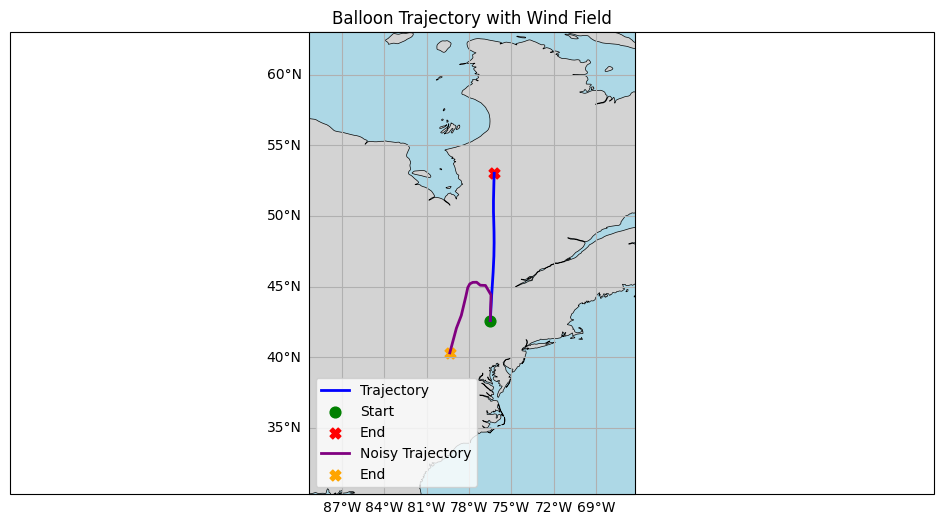

In [9]:
plot_trajectory_map(longitudes, latitudes, noisy_longitudes, noisy_latitudes)

# **Generating Actions using Iterative Optimization**

This section takes a little longer to run. Note: If your computer gets noticeably slower, clear the above outputs as the Globe visualizations might use a lot of resources.

We will compare the actions and trajectories of balloons in a noiseless and noisy environment, but now using Iterative Optimization instead of Tree Search.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from env.balloon_env import BalloonERAEnvironment
from agent.mppi_agent import MPPIAgent

# ------PARAMETERS---------
initial_lat, initial_lon = 42.6, -76.5 #deg
initial_alt = 10.0 #km
initial_volume = 1000.0  # Initial volume (m³)
initial_sand = 100  # Initial sand mass (kg)
start_time_np = ds.valid_time.values[0]
start_time = pd.to_datetime(start_time_np).to_pydatetime()
duration_seconds = 24*3600
dt_seconds = 300
n_steps = int(duration_seconds / dt_seconds)
n_steps=10
# For visualization
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

np.random.seed(0)  # For reproducible results
#-----------------------------

In [ ]:
# Run the agent with noiseless wind field
start_time = dt.datetime(2024, 7, 1, 0, 0)
env = BalloonERAEnvironment(initial_lat=42.6, initial_lon=-76.5, initial_alt=10.0,
                            target_lat= None, target_lon=None, target_alt=None, 
                            ds=ds, start_time=start_time, viz=False, add_noise=False, objective='fly', dt=environment_step)

agent= MPPIAgent(horizon=5, objective='fly') # horizon is low to have faster computation time, so differences might not be as evident
state = env.reset()
opt_actions = []

latitudes = []
longitudes = []
altitudes = []

latitudes.append(env.balloon.lat)
longitudes.append(env.balloon.lon)
altitudes.append(env.balloon.alt)

# Generating action one step at a time and tracking path + resources
for step in range(n_steps):
  action = agent.select_action(state, env, step)
  opt_actions.append(action)
  state, _, done, _ = env.step(action)
  latitudes.append(env.balloon.lat)
  longitudes.append(env.balloon.lon)
  altitudes.append(env.balloon.alt)
  if done:
    print(f"Terminated")
    break
  print(f"On step {step}")

WindField initialized with noise enabled: False, scale: 1.0
On step 0
On step 1
On step 2
On step 3
On step 4
On step 5
On step 6
On step 7
On step 8
On step 9


In [13]:
env = BalloonERAEnvironment(initial_lat=42.6, initial_lon=-76.5, initial_alt=10.0,
                            target_lat= None, target_lon=None, target_alt=None, 
                            ds=ds, start_time=start_time, viz=False, add_noise=False, objective='fly', dt=environment_step)

longitudes, latitudes, pressure_profile, velocities, helium_masses, sand_masses = get_trajectory_info(env, len(opt_actions), opt_actions)

noisy_env = BalloonERAEnvironment(initial_lat=42.6, initial_lon=-76.5, initial_alt=10.0,
                            target_lat= None, target_lon=None, target_alt=None, 
                            ds=ds, start_time=start_time, viz=False, add_noise=True, noise_scale=20.0, noise_seed=100, objective='fly', dt=environment_step)

noisy_longitudes, noisy_latitudes, noisy_pressure_profile, noisy_velocities, noisy_helium_masses, noisy_sand_masses = get_trajectory_info(noisy_env, len(opt_actions), opt_actions)

WindField initialized with noise enabled: False, scale: 1.0
WindField initialized with noise enabled: True, scale: 20.0


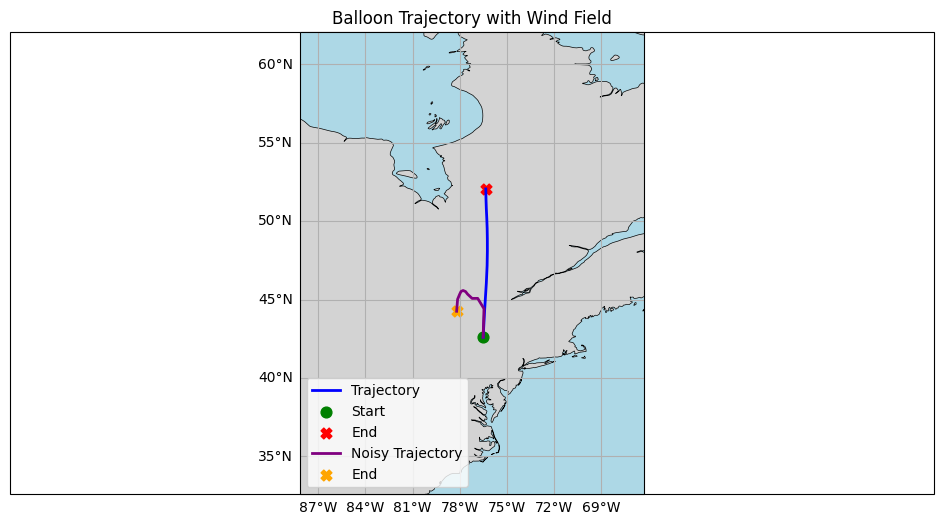

In [14]:
plot_trajectory_map(longitudes, latitudes, noisy_longitudes, noisy_latitudes)